# STARDUST interactive

This Jupyter Notebook provides an interactive version of STARDUST signal extraction. Functions are defined and imported from util.py. Use help() to see the documentation. For a more detailed description of the STARDUST pipeline, please see the biorxiv paper and github page for more information. 

## 1. Environment set up

In [27]:
import os, scipy, sys, pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from src.STARDUST.util import * # import functions from util.py

## 2. Data input

In [28]:
# input input and output directories
input_dir = input('Enter the path to the folder containing the input files: ')
output_dir = input('Enter the path to the folder containing the output files: ')

In [29]:
# input metadata related to the experiment
keyword = input('Enter the common keyword in input file (csv, ROA mask and cell mask) names: ')
drug_frame = float(input('Enter the frame number of drug application (enter 0 if no drug was applied): '))
frame_rate = float(input("Enter the frame rate (in Hz) of the recording (e.g. 1): "))
spatial_resolution = float(input('Enter the spatial resolution of the recording (in µm/pixel, if one pixel size is 0.884 x 0.884 µm^2, enter 0.884): '))
output_filename = input('Enter the output file name: ')
output_path = os.path.join(output_dir, output_filename)

Find input file paths using find_files(). Note that the current code assumes that the input time-series data is stored in a csv, and ends with "signals.csv", the ROA mask is stored as a tiff file with keyword "ROA", and similarly the cell mask is a tiff file with keyword "cell". 

You can also directly input the paths. 

In [ ]:
# find the input files using find_files function
csv_path, ROA_mask_path, cell_mask_path = find_files(input_dir, keyword)

In [30]:
csv_path = '/Users/mikodai/Library/CloudStorage/Box-Box/Calcium imaging analysis Miko/20240522/20240522_slice1_NE 20uM_washout/20240522_slice1_NE 20uM_washout_signals.csv'
ROA_mask_path = '/Users/mikodai/Library/CloudStorage/Box-Box/Calcium imaging analysis Miko/20240522/20240522_slice1_NE 20uM_washout/20240522_slice1_NE 20uM_washout_10to12_peakremoved_ROAmask.tif'

Next, read in ROA mask and cell mask. 

Reading in file:  /Users/mikodai/Library/CloudStorage/Box-Box/Calcium imaging analysis Miko/20240522/20240522_slice1_NE 20uM_washout/20240522_slice1_NE 20uM_washout_10to12_peakremoved_ROAmask.tif
This ROA mask contains 1268 ROAs.




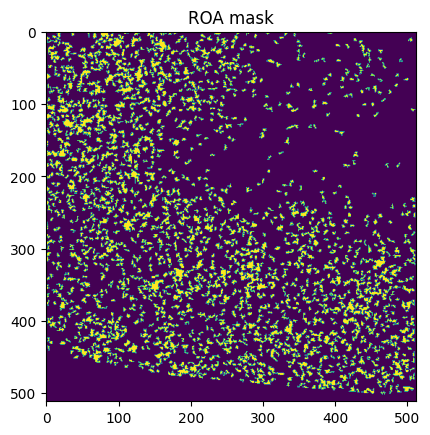

In [57]:
ROA_map_array, ROA_map_labeled, ROA_map_count = read_tif(ROA_mask_path, "ROA")
#cell_map_array, cell_map_labeled, cell_count = read_tif(cell_mask_path, "cell")

visualize_map(ROA_map_array = ROA_map_array)

## 3. Signal preprocessing

In [32]:
# Smooth traces using a filter
raw_traces, filtered_traces = raw_to_filtered(csv_path)

Reading in file:  /Users/mikodai/Library/CloudStorage/Box-Box/Calcium imaging analysis Miko/20240522/20240522_slice1_NE 20uM_washout/20240522_slice1_NE 20uM_washout_signals.csv 


Applying a lowpass Butterworth filter with a 4 th order filter at the cutoff of 0.4 Hz


In [33]:
ROA_count, frame_count = check_traces(filtered_traces)

The current file contains: 
Number of ROA:  1268
Number of frames:  698


### Optinal: Signal correction using linear regression

This optional step uses the correct_shift() function to detect and correct gradual linear drift in the traces. Ideally, the slope distribution histogram should roughly center around zero. If the distribution is not centered around zero, it might indicate photobleaching or a significant z drift during the recording. 

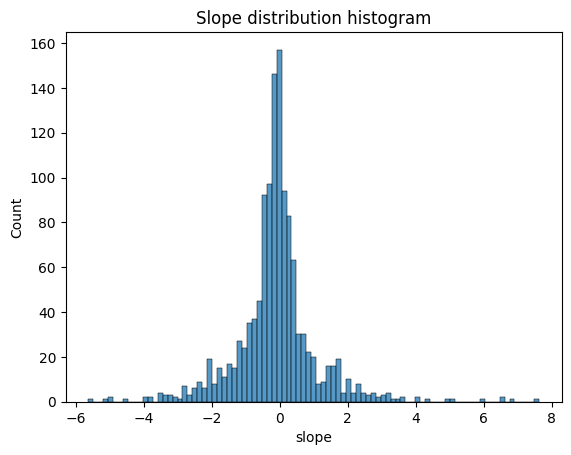

In [34]:
# optional: correct traces for shift using linear regression
corrected_traces, reg = correct_shift(filtered_traces)

## 4. Baseline determination and signal detection

In [ ]:
help(iterative_baseline)

In [35]:
# baseline determination
dff_traces, baselines, thresholds, signal_frames, signal_boundaries, signal_threshold = iterative_baseline(corrected_traces)

Using signal threshold of 3.0* SD and detecting baseline from frame 0 to -1.

Processing round 1 of signal detection...
ROAs with signal:  1195
ROAs without signal:  73

Processing round 2 of signal detection...
ROAs with signal:  1193
ROAs without signal:  75

Processing round 3 of signal detection...
ROAs with signal:  1194
ROAs without signal:  74

Processing round 4 of signal detection...
ROAs with signal:  1192
ROAs without signal:  76

Processing round 5 of signal detection...
ROAs with signal:  1194
ROAs without signal:  74

Processing round 6 of signal detection...
ROAs with signal:  1191
ROAs without signal:  77



## Checkpoint 1: dF/F traces heatmap

Visualze dF/F traces using heatmap. Each row represents one ROA and each column represents one frame.  

Note that for heatmap coloring, *vmin* is set at 0, and *vmax* is set at (signal_threshold + 2) * average thresholds across all ROAs. For example, if the signal_threshold is set at 3SD, any transients that has a dF/F value above baseline + 5SD will be colored red to facilitate visualization. You can adjust the vmax parameter if needed. 

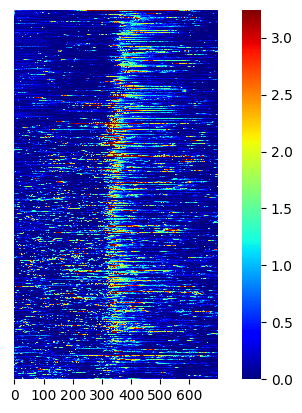

In [37]:
sns.heatmap(dff_traces, vmin = 0, vmax = (signal_threshold + 2) * thresholds.mean(), 
            xticklabels=100, yticklabels= False, cmap = 'jet', square = True);

## 5. Signal feature extraction

In [38]:
signal_stats = analyze_signal(dff_traces, signal_frames, signal_boundaries, frame_rate, drug_frame)

In [39]:
signal_stats.head()

,ROA_ID,signal_start_frame,signal_start_time,signal_end_frame,signal_end_time,peak_frame,peak_time,AUC,amplitude,signal_to_noise,rise_time,decay_time,half_width,duration,inter_event_interval,epoch
0,1,104,97.353497,211,198.487713,126,119.092628,42.825036,0.979743,1.108516,18.716206,62.365447,0.454358,101.134216,NaN,baseline
1,1,302,284.499055,426,401.701323,337,318.525520,43.785577,1.351646,1.529300,10.844446,34.869337,0.635887,117.202268,86.011342,drug
2,3,191,179.584121,615,580.340265,359,339.319471,4083.765305,31.420987,12.892877,102.030092,192.057141,14.830085,400.756144,NaN,drug
3,5,43,39.697543,64,59.546314,46,43.478261,5.004830,0.701332,0.496446,2.354363,14.497908,0.328661,19.848771,NaN,baseline
4,5,64,59.546314,109,102.079395,67,63.327032,10.102613,1.437632,1.017645,2.290574,6.565783,0.676629,42.533081,0.000000,baseline


## 6. ROA and cell assignment

In [ ]:
# add corresponding cell ID to the signal stats
df_ROA_cell = align_ROA_cell(ROA_map_labeled, cell_map_labeled, ROA_map_count, spatial_resolution)
signal_stats = pd.merge(df_ROA_cell, signal_stats, on = 'ROA_ID', how = 'right')

In [ ]:
signal_stats.head(10)

### ROA based analysis

Note that ROAs that do not have any cell assignment is listed as cell 0 for cell ID. 

In [ ]:
ROA_based, df_ROA_cell = ROA_analysis(signal_stats, df_ROA_cell, frame_count, frame_rate, drug_frame)

In [ ]:
ROA_based.head()

### Cell based analysis

Note that ROAs that do not have any cell assignment is listed as cell 0 for cell ID. This cell should be omitted in later analysis. 

In [ ]:
cell_based = cell_analysis(signal_stats, df_ROA_cell)

In [ ]:
cell_based.head()

## Checkpoint 2: ROA stats

In [ ]:
sns.histplot(data = ROA_based, x = 'frequency_permin');

In [ ]:
ROA_summary = df_ROA_cell.groupby('ROA_type').count()
ROA_summary

## Checkpoint 3: Individual traces
Use the inspect_trace() function to visualize traces. 

### Visualize inactive ROAs
The following example checks all ROAs that are "inactive" based on our pipeline but was intially determined as active ROA by AQuA. 

In [ ]:
inactive_ROAs = df_ROA_cell[df_ROA_cell['ROA_type'] == 'inactive']['ROA_ID'].to_list()
inspect_trace(inactive_ROAs, dff_traces, baselines, thresholds, drug_frame)

### Visualize ROAs with large slope during optional correction

In [ ]:
check_ROAs = pull_largeslope_traces(ROA_count, reg)
inspect_trace(check_ROAs, dff_traces, baselines, thresholds, drug_frame)

### Visualize a few randomly selected ROAs

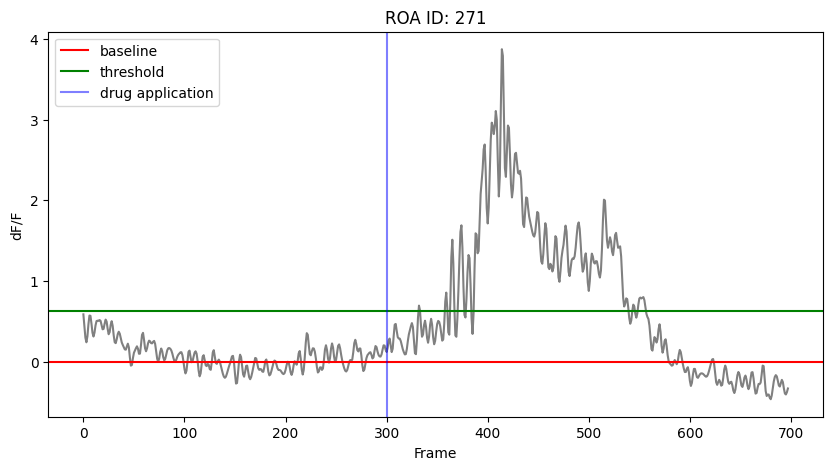

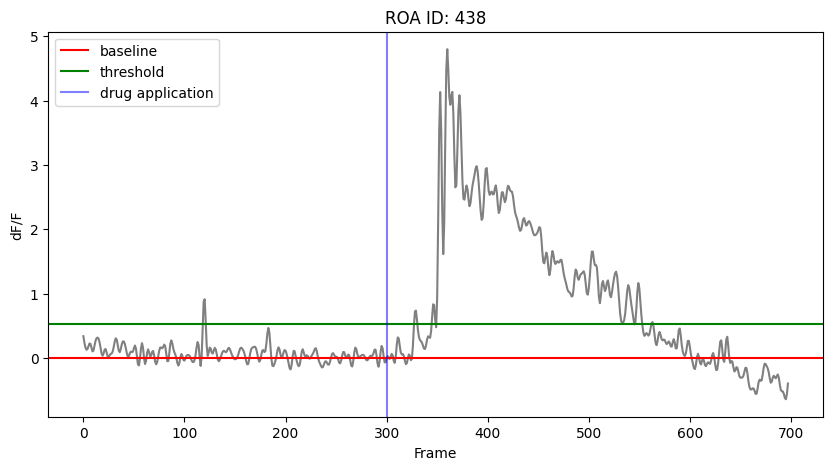

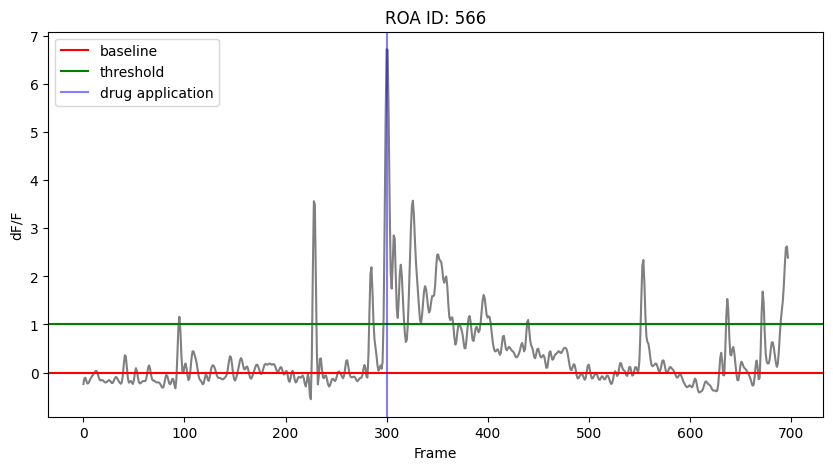

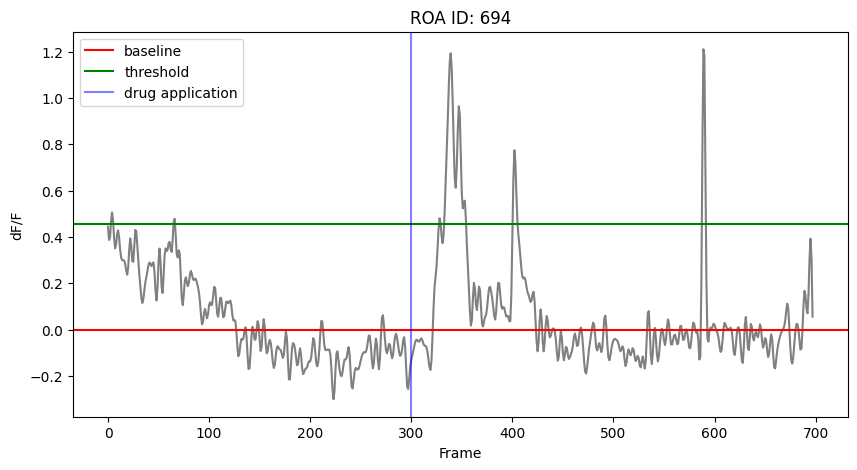

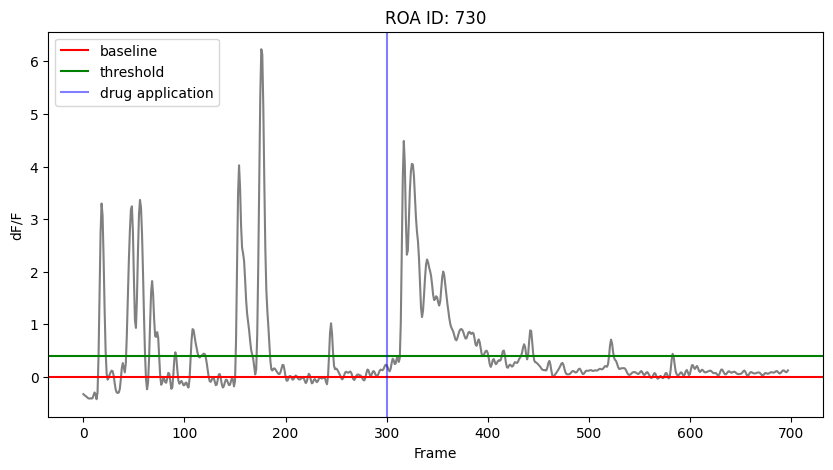

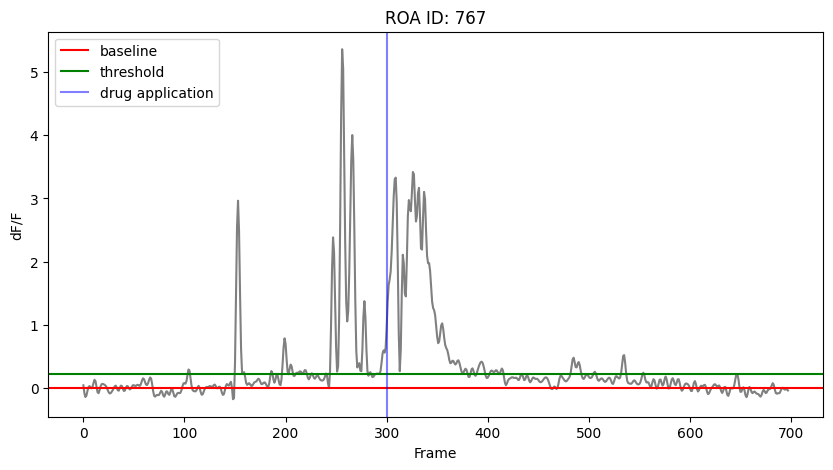

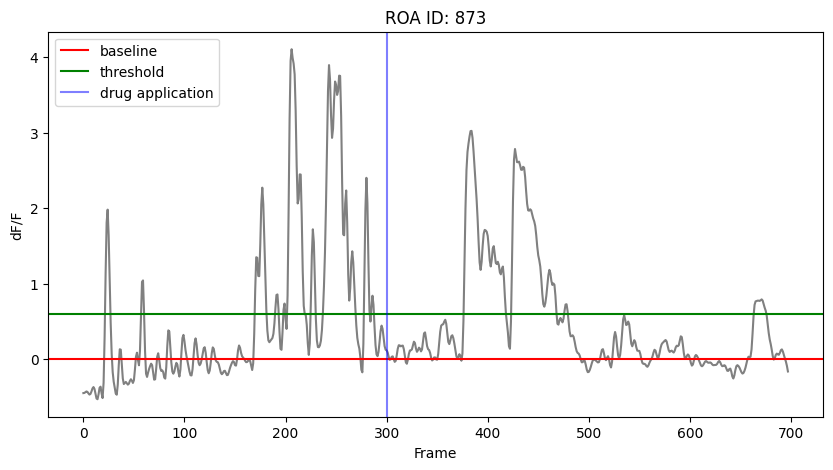

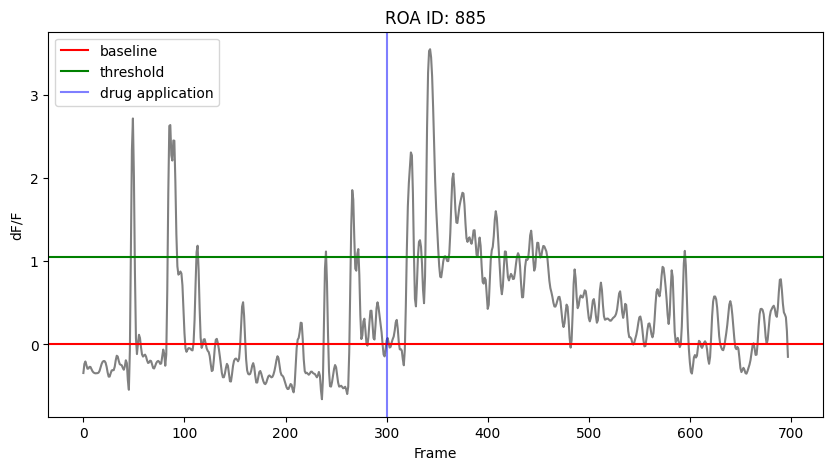

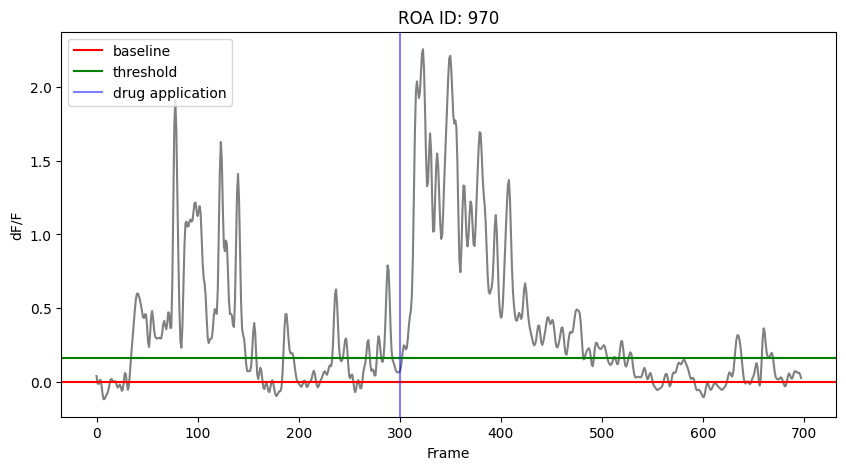

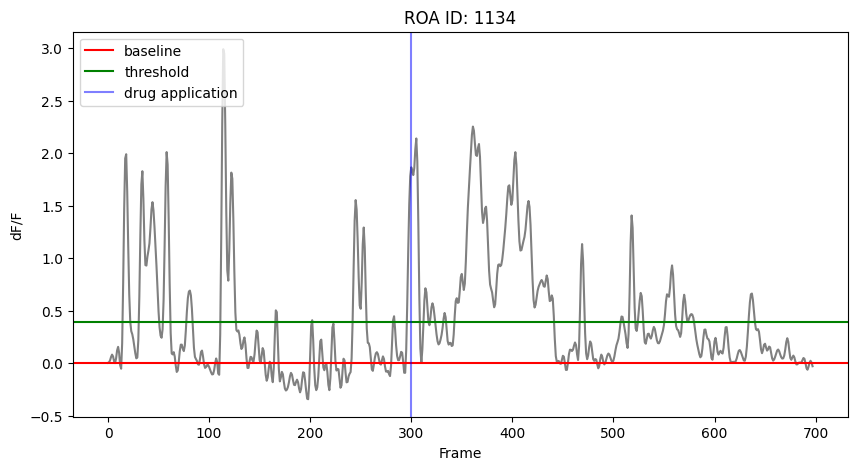

In [79]:
random_ROAs = np.random.choice(ROA_count, 10)
random_ROAs.sort()
inspect_trace(random_ROAs, dff_traces, baselines, thresholds, drug_frame)

In [78]:
random_ROAs

<function ndarray.sort>

## 7. Data output

In [ ]:
metadata = metadata_todf()
output_data(save_as = 'csv')